<a href="https://colab.research.google.com/github/ziedjouini/Churn_telecom-z/blob/main/Churn_telecom_CK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import sketch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def df_info(df):
    print("Nombre de lignes : ", df.shape[0])
    print("Nombre de colonnes : ", df.shape[1])
    df_info = pd.DataFrame(df.dtypes, columns=['Type'])
    df_info['Nb valeurs manquantes'] = df.isnull().sum()
    df_info['Nb valeurs uniques'] = df.nunique()
    df_info['Valeurs uniques'] = df.apply(lambda x: x.unique())
    return df_info

# importation

In [ ]:
link = "https://raw.githubusercontent.com/murpi/wilddata/master/quests/churn_telecom.csv"
source_chunk = pd.read_csv(link)
source_chunk = source_chunk[['tenure', 'InternetService', 'Contract', 'MonthlyCharges', 'Churn']]
df_info(source_chunk)

Nombre de lignes :  7043
Nombre de colonnes :  5


,Type,Nb valeurs manquantes,Nb valeurs uniques,Valeurs uniques
tenure,int64,0,73,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ..."
InternetService,object,0,3,"[Fiber optic, DSL, No]"
Contract,object,0,3,"[Month-to-month, One year, Two year]"
MonthlyCharges,float64,0,1585,"[29.85, 56.95, 53.85, 42.3, 70.7, 99.65, 89.1,..."
Churn,object,0,2,"[Yes, No]"


# analyse

In [ ]:
# Calculate the churn rate
total_customers = source_chunk.shape[0]
churn_count = source_chunk['Churn'].value_counts()['Yes']
churn_rate = churn_count / total_customers
print('Taux d\'attrition: {:.2f}%'.format(churn_rate*100))

Taux d'attrition: 31.51%


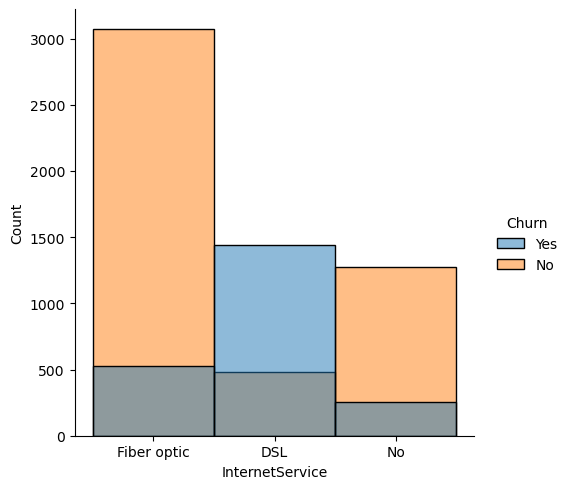

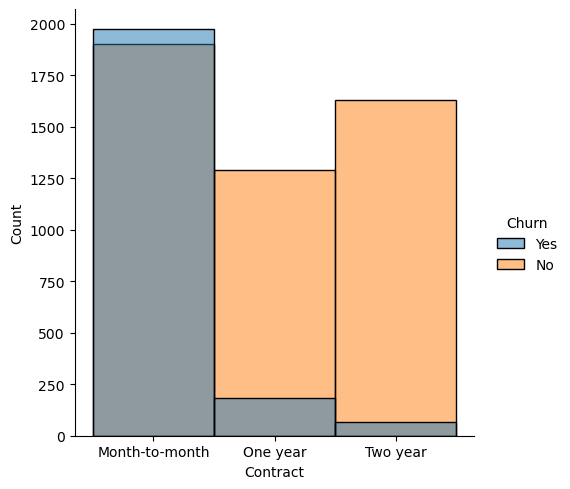

In [ ]:
for col in source_chunk:
    if source_chunk[col].dtype == 'object' and col != 'Churn':
        sns.displot(x=col, hue='Churn', data=source_chunk)

Text(0.5, 1.0, "Pourcentage de type de service internet par rapport a ceux qui ont quitté l'entreprise")

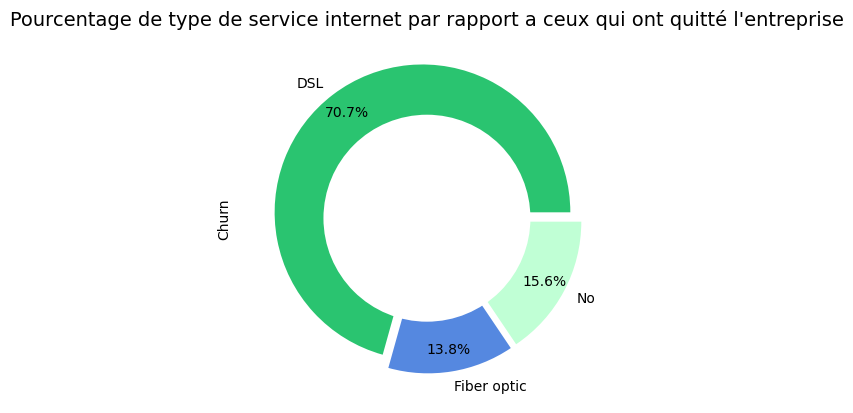

In [ ]:
# colors
colors = ['#2ac470', '#5588e0', '#c0ffd5']
# explosion
explode = (0.05, 0.05, 0.05)

# pourcentage de type de service internet par rapport a ceux qui ont quitté l'entreprise 
source_chunk.groupby('InternetService')['Churn'].value_counts(normalize=True)[:,'Yes'].plot(kind='pie', explode=explode, colors=colors, autopct='%1.1f%%', pctdistance=0.85)
# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

# ajouter un titre
plt.title('Pourcentage de type de service internet par rapport a ceux qui ont quitté l\'entreprise', fontsize=14)

> conclusion : on peut voir avec évidence que les clients qui résilient leur contrat sont en grande majorité sous contrat mensuel et on le type de service internet DSL

# ML

In [ ]:
chunk = source_chunk.copy()
# factorise colonne churn
chunk['Churn'] = chunk['Churn'].factorize()[0]

In [ ]:
# matrix de corrélation
chunk.corr()

,tenure,MonthlyCharges,Churn
tenure,1.000000,0.247900,0.463944
MonthlyCharges,0.247900,1.000000,-0.111523
Churn,0.463944,-0.111523,1.000000


### train test split et evaluation

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

# Separate the target variable (Churn) from the rest of the dataframe
X = chunk.drop('Churn', axis=1)
y = chunk['Churn']

# Encode categorical variables using LabelEncoder
le = LabelEncoder()
X['InternetService'] = le.fit_transform(X['InternetService'])
X['Contract'] = le.fit_transform(X['Contract'])

# Split the data into training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

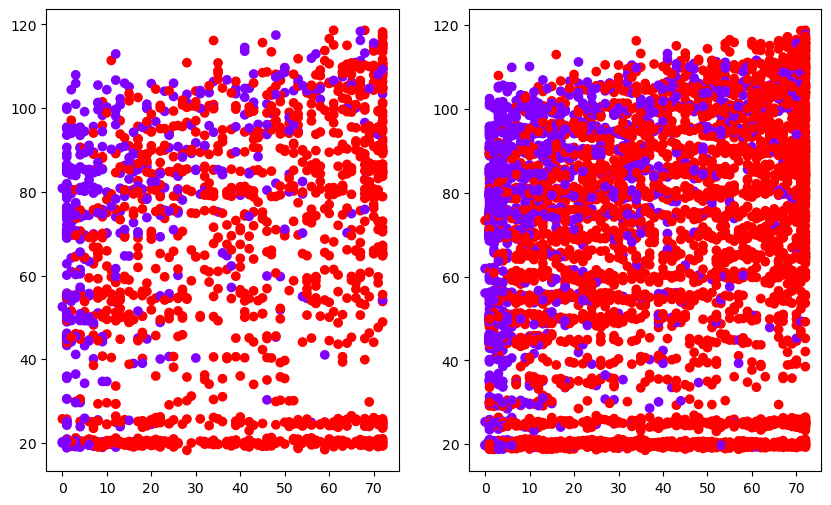

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.scatter(X_train['tenure'], X_train['MonthlyCharges'], c=y_train, cmap='rainbow')
plt.subplot(122)
plt.scatter(X_test['tenure'], X_test['MonthlyCharges'], c=y_test, cmap='rainbow')

### evaluation elbow des clusters

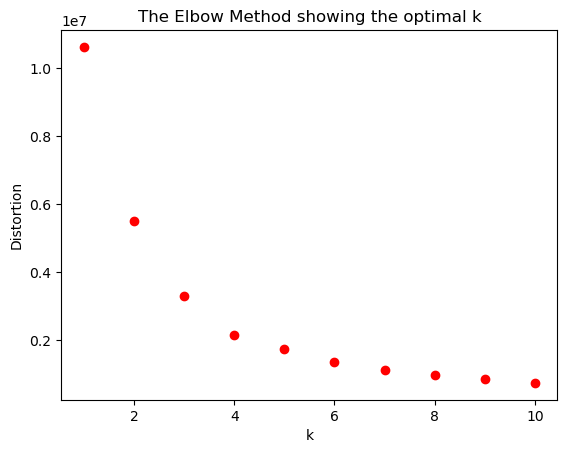

In [ ]:
# evaluation elbow method
from sklearn.cluster import KMeans
distortions = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

plt.plot(range(1, 11), distortions, 'ro')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


### Clustering

In [ ]:
# the best number of clusters is 3
modelKM = KMeans(n_clusters=3)
kmeans = modelKM.fit(X)

cluster = modelKM.cluster_centers_
label = modelKM.labels_

df_cluster = pd.DataFrame(cluster, columns=X.columns)
df_cluster

,tenure,InternetService,Contract,MonthlyCharges
0,58.201357,0.785068,1.151131,89.958643
1,27.838791,1.479849,0.819899,28.488329
2,13.485516,0.566299,0.149327,77.294492


<AxesSubplot: xlabel='MonthlyCharges', ylabel='tenure'>

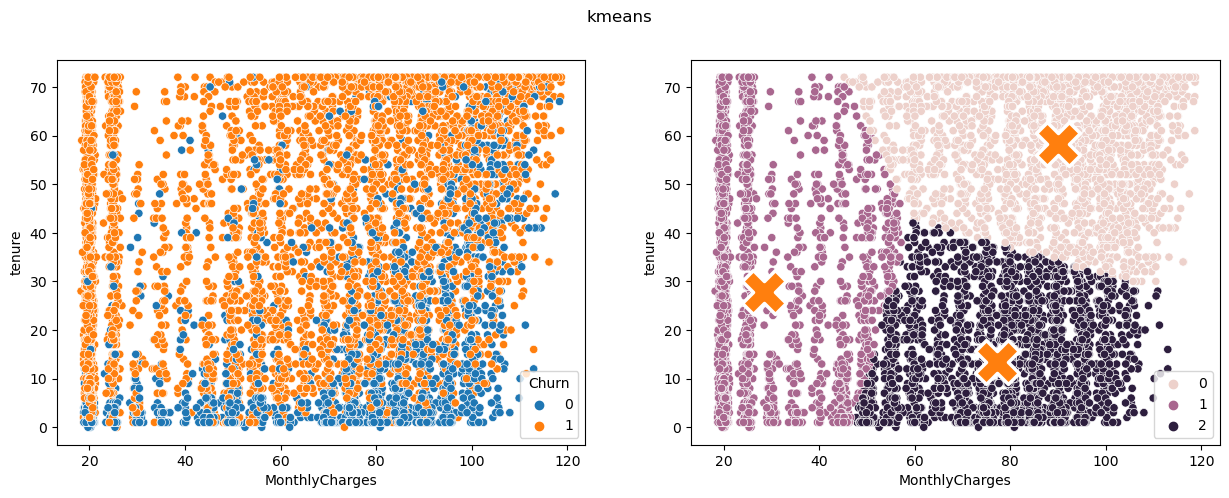

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
fig.suptitle('kmeans')

sns.scatterplot(data=chunk, x='MonthlyCharges', y='tenure', hue='Churn', ax=axes[0])

sns.scatterplot(data=chunk, x='MonthlyCharges', y='tenure', hue=label, ax=axes[1], legend='full') # 3 clusters
sns.scatterplot(data=df_cluster, x='MonthlyCharges', y='tenure', ax=axes[1], marker='X', s=1000) # centroides

### entrainement du model et prediction

In [ ]:
# Train a Random Forest Classifier on the training set 
clf = RandomForestClassifier(n_estimators=100, random_state=42) 
clf.fit(X_train, y_train) 

# Make predictions on the test set 
y_pred = clf.predict(X_test) 
clf.score(X_test, y_test), clf.score(X_train, y_train)

(0.8623887942456937, 0.9948863636363636)

In [ ]:
# apply the model to the whole dataset
y_pred = clf.predict(X)

# add the prediction to the dataframe
source_chunk['prediction'] = y_pred

In [ ]:
# filtrer le churn sur No
source_chunk = source_chunk[source_chunk['Churn'] == 'No']
# calculer le pourcentage de prediction sur le churn
total_customers = source_chunk.shape[0]
churn_count = source_chunk['prediction'].value_counts()[0] # selectionne les predictions en risque de churn
churn_rate = churn_count / total_customers
print('Taux de client à risque : {:.2f}%'.format(churn_rate*100))

Taux de client à risque : 7.13%


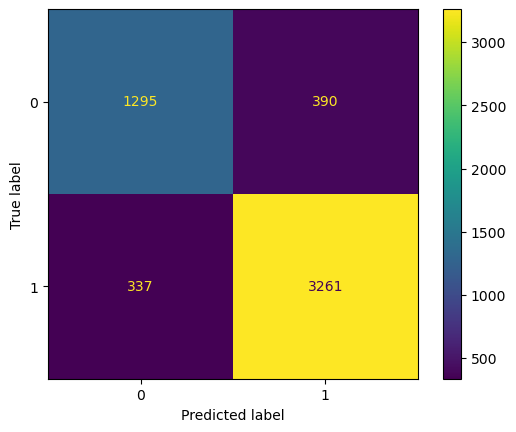

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# confusion_matrix(y_test, clf.predict(X_test))

# Print the classification report
# print(classification_report(y_test, clf.predict(X_test)))

# plot_confusion_matrix
cm = confusion_matrix(y_test, clf.predict(X_test), labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()

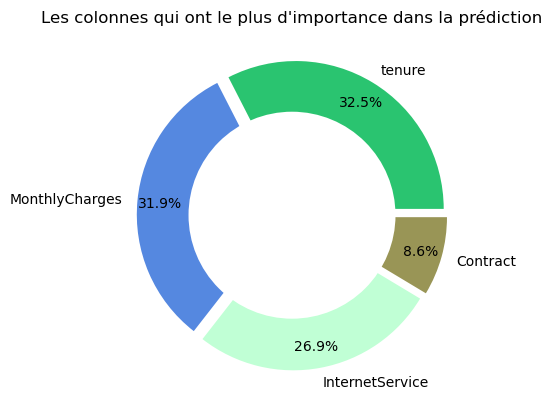

In [ ]:
# colonnes qui ont le plus d'importance dans la prédiction
importances = pd.DataFrame({'feature':X.columns,'importance':np.round(clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.reset_index(inplace=True)

# Setting labels for items in Chart
feat = importances['feature'].tolist()
  
# Setting size in Chart based on 
# given values
impo = importances['importance'].tolist()
  
# colors
colors = ['#2ac470', '#5588e0', '#c0ffd5', 
          '#999556']
# explosion
explode = (0.05, 0.05, 0.05, 0.05)
  
# Pie Chart
plt.pie(impo, colors=colors, labels=feat,
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode)

# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
  
# Adding Title of chart
plt.title('Les colonnes qui ont le plus d\'importance dans la prédiction')

# Displaying Chart
plt.show()